# PMR3508-2024-70

Classification of Adult Database (from Kaggle) using k-Nearest Neighbor (kNN)

This Notebook is divided in two main sections:
1. Exploratory Analysis
2. Classifier Development

First, we import the libraries that we're going to use

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Then, we import the Adult dataset into a Pandas DataFrame.

In [43]:
df = pd.read_csv('data/train_data.csv')

## 1. Exploratory Analysis

In this section, we take a first look at the dataset to gain some insights of the data.


In [44]:
df.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


Obviously, the Id is not a feature. We set it as the index:

In [45]:
# inplace modify the df rather than creating a new one
df.set_index("Id", drop=True, inplace=True) 

In [54]:
# Sort the dataset by the Id
df.sort_index(ascending=True, inplace=True)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
Id,,,,,,,,,,,,,,,
16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [34]:
print(df.shape)

(32560, 15)


Distribution of Numerical Values

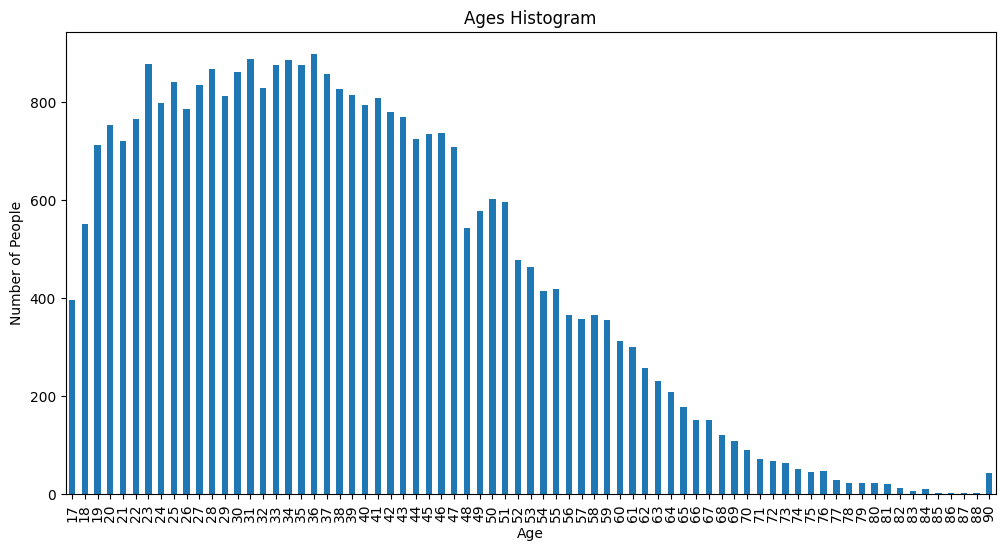

In [60]:
plt.figure(figsize=(12,6))
df['age'].value_counts().sort_index().plot(kind="bar")
plt.title("Ages Histogram")
plt.xlabel("Age")
plt.ylabel("Number of People")
plt.show()

In [71]:
f"Average Age: {df['age'].mean():.2f}"

'Average Age: 38.58'

plt.figure(figsize=())